# Publishing Figures - Single Kappa (free troposphere)
This obtains all figures for a comparison between two simulations of neighbouring optical depth that require the free troposphere as well as surface variables.

In [574]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.stats import z_score_from_confidence_interval
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
from sklearn.linear_model import TheilSenRegressor
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [12]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 0.6
tau_lw_warm = 1
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [13]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [14]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Chose whether to only consider summer days or consider all days
season = 'all'
# season = 'summer'
# season = 'winter'
if season == 'summer':
    season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    season_months = {'nh': [12, 1, 2], 'sh': [6, 7, 8]}   # JJA for NH and DJF for SH

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:22<00:00, 11.40s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [381]:
def lambda_adiabat_fit_func(temp_ft, mse_surf, z_ft):
    # Adiabatic FT temperature is such that surf MSE equals free trop MSE
    return moist_static_energy(temp_ft, sphum_sat(temp_ft, pressure_ft_actual), z_ft) - mse_surf

In [594]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
z_mean = np.zeros((n_exp, n_pressure, n_lat))
r_mean = np.zeros((n_exp, n_lat))           # relative humidity
lapse_mean = np.zeros((n_exp, n_lat))
lapse_adiabat_mean = np.zeros((n_exp, n_lat))
temp_adiabat_mean = np.zeros((n_exp, n_lat))

# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_quant3_std = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
r_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
lapse_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
lapse_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
temp_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting

with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.isel(pfull=ind_surf).mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.mean(dim='lon_time')
        mse = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], ds_all[i].height[ind_surf])
        mse_ft = moist_static_energy(ds_all[i].temp[ind_ft], sphum_sat(ds_all[i].temp[ind_ft], pressure_ft_actual), 
                                     ds_all[i].height[ind_ft])
        mse_mean[i, ind_surf] = mse.mean(dim='lon_time')
        mse_mean[i, ind_ft] = mse_ft.mean(dim='lon_time')
        r_mean[i] = (ds_all[i].sphum/sphum_sat(ds_all[i].temp, p_surface)).isel(pfull=ind_surf).mean(dim='lon_time')
        lapse_mean[i] = -((ds_all[i].temp[ind_ft]-ds_all[i].temp[ind_surf])/(ds_all[i].height[ind_ft]-ds_all[i].height[ind_surf])).mean(dim='lon_time')
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            temp_adiabat_mean[i, k] = scipy.optimize.fsolve(lambda_adiabat_fit_func, 273, args=(mse_mean[i, ind_surf, k], 
                                                                                                z_mean[i, ind_ft, k]))
            lapse_adiabat_mean[i, k] = -(temp_adiabat_mean[i, k]-temp_mean[i, ind_surf, k])/(z_mean[i, ind_ft, k]-z_mean[i, ind_surf, k])
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                sphum_quant3[i, k, j] = ds_all[i].sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                z_quant3[i, :, k, j] = ds_all[i].height[:, k, use_ind].mean(dim='lon_time')
                mse_quant3[i, ind_surf, k, j] = mse[k, use_ind].mean(dim='lon_time')
                mse_quant3_std[i, ind_surf, k, j] = mse[k, use_ind].std(dim='lon_time')
                mse_quant3[i, ind_ft, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                mse_quant3_std[i, ind_ft, k, j] = mse_ft[k, use_ind].std(dim='lon_time')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                lapse_quant3[i, k, j] = -((ds_all[i].temp[ind_ft]-ds_all[i].temp[ind_surf])/(ds_all[i].height[ind_ft]-ds_all[i].height[ind_surf]))[k, use_ind].mean(skipna=True)   
                temp_adiabat_quant3[i, k, j] = scipy.optimize.fsolve(lambda_adiabat_fit_func, 273, 
                                                                     args=(mse_quant3[i, ind_surf, k, j], z_quant3[i, ind_ft, k, j]))
                lapse_adiabat_quant3[i, k, j] = -(temp_adiabat_quant3[i, k, j]-temp_quant3[i, ind_surf, k, j]
                                                  )/(z_quant3[i, ind_ft, k, j] - z_quant3[i, ind_surf, k, j])
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)

# Get kappa = z_ft / T_ft
kappa_quant3 = np.asarray([z_quant3[i, ind_ft] / temp_quant3[i, ind_ft] for i in range(n_exp)])
kappa_mean = np.asarray([np.expand_dims(z_mean[i, ind_ft]/temp_mean[i, ind_ft], axis=-1) for i in range(n_exp)])

100%|██████████| 2772/2772 [00:55<00:00, 49.56it/s]


## $\lambda_1$ Problem
Below, I show that $\lambda_1 = \delta h(x)/\delta h^*_{FT}(x)>1$ for all $x$ (blue line), and is larger for small $x$ when convection is not taking place. But the assumption of convective quasi-equilibrium expects $\lambda_1 \approx 1$.

I want to come up with a theory to explain why we don't see $\lambda_1 \approx 1$.

In [595]:
lambda_1 = (mse_quant3[1] - mse_quant3[0])[0] / (mse_quant3[1]-mse_quant3[0])[1]
lambda_2 = (mse_quant3[1]-mse_quant3[0])[1] / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[1]
lambda_3 = (mse_mean[1]-mse_mean[0])[0] / (mse_mean[1]-mse_mean[0])[1]
labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
          '$\lambda_1(x)$',
          '$\lambda_2(x)$',
          '$\overline{\lambda_1}$']

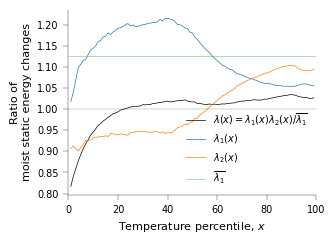

In [596]:
save_lambda_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quantiles_all, np.average(var, axis=0, weights=lat_weights),
            color=use_color, label=labels[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(np.average(lambda_3, axis=0, weights=lat_weights), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.legend()
ax.set_xlim(0, 100)
# ax.set_ylim(0.93, 1.27)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Using $dh/dT$ in theory
MSE is given by $h = c_pT + L_v q$.

The gradient with temperature is given by: $\frac{dh}{dT} = c_p + L_v\alpha q + L_v q^* \frac{dr}{dT}$

Averaged over all days, $\frac{dr}{dT} \approx 0$, so we have $\overline{\frac{dh}{dT}} \approx c_p + L_v\bar{\alpha} \bar{q}$.

If we assume that for non-convective days, $dh/dT$ is constant then we can write: $h(x) \approx \overline{h} + \overline{\frac{dh}{dT}}(T(x) - \overline{T})$

Taking the difference of this between simulations, we get:

$\delta \left(\overline{\frac{dh}{dT}}\right) = L_v \bar{\alpha} \overline{q^*} \delta \overline{r} + 
L_v \overline{\alpha} \frac{\overline{q}}{\overline{T}}(\bar{\alpha} \bar{T} - 2)\delta \overline{T}$

which we can substitute into $\delta h(x) \approx \delta \overline{h} + \delta \left(\overline{\frac{dh}{dT}}\right)(T(x) - \overline{T}) + \overline{\frac{dh}{dT}} \delta (T(x) - \overline{T})$

In [597]:
def get_empirical_dhdT(temp, mse, temp_mean, mse_mean, confidence = 0.9):
    """
    Gets gradient of MSE vs Temp which is forced to go through the mean temp and mean mse.

    Args:
        temp: [n_data]
            Data used to find gradient
        mse: [n_data]
            Data used to find gradient - one for each temperature
        temp_mean: float
        mse_mean: float
        confidence: float
            Desired confidence in temperature

    Returns:
        float
            Gradient
        float
            Confidence value for the gradient, such that there is the desired confidence 
            in ± this value about returned gradient.
    """
    fit_func = lambda x, m: mse_mean + m*(x-temp_mean)     # Straight line through the ref point
    param, pcov = scipy.optimize.curve_fit(fit_func,temp, mse)[:2]
    # param_with_error = uncertainties.correlated_values(param, pcov)[0]
    # param_std = param_with_error.std_dev
    param_std = np.sqrt(pcov)
    z_score = z_score_from_confidence_interval(confidence)
    return float(param), float(z_score * param_std)

def get_theory_dhdT(temp_mean, sphum_mean, drdT_mean=0):
    """
    Returns the theoretical estimate for dh/dt for a particular experiment.
    
    Args:
        temp_mean: float
        sphum_mean: float
        drdT_mean: float

    Returns:
        float
            Gradient in units of kJ/kg/Kelvin
    """
    alpha_mean = clausius_clapeyron_factor(temp_mean, p_surface)
    q_sat_mean = sphum_sat(temp_mean, p_surface)
    return (c_p + L_v * alpha_mean * sphum_mean + L_v * q_sat_mean * drdT_mean)/1000

def get_mean_drdT(exp_ind, lat_ind):
    # Returns gradient of relative humidity with temperature for given experiment and latitude in ds_all.
    ds_use = ds_all[exp_ind].isel(pfull=ind_surf, lat=lat_ind)
    return np.polyfit(ds_use.temp, ds_use.sphum/sphum_sat(ds_use.temp, p_surface), deg=1)[0]

def get_theory_delta_dhdT(temp_mean, sphum_mean, rh_mean):
    """
    Returns the theoretical estimate for the change in dh/dt between experiments with different optical depths.
    The mean value for both experiments needs to be provided
    
    Args:
        temp_mean: [n_exp]
        sphum_mean: [n_exp]
        rh_mean: [n_exp]

    Returns:
        float
            Gradient change in units of kJ/kg/Kelvin
    """
    # This ignores the dr/dt term
    alpha_mean = clausius_clapeyron_factor(temp_mean[0], p_surface)
    q_sat_mean = sphum_sat(temp_mean[0], p_surface)
    delta_rh = rh_mean[1] - rh_mean[0]
    delta_T = temp_mean[1] - temp_mean[0]
    return (L_v * alpha_mean * q_sat_mean * delta_rh  + \
        L_v * alpha_mean * sphum_mean[0]/temp_mean[0] * (alpha_mean * temp_mean[0] - 2) * delta_T) / 1000

In [598]:
dh_dT_empirical = np.zeros((n_exp, n_lat))
dh_dT_theory = np.zeros((n_exp, n_lat))
delta_dh_dT_theory = np.zeros(n_lat)
mse_empirical_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
mse_theory_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
delta_mse_theory_quant3 = np.zeros((n_lat, n_quant_all))
delta_mse_theory_const_std_quant3 = np.zeros((n_lat, n_quant_all))
dr_dT_mean = np.zeros((n_exp, n_lat))
ignore_drdT = True
for j in range(n_lat):
    delta_dh_dT_theory[j]  = get_theory_delta_dhdT(temp_mean[:, ind_surf, j], sphum_mean[:, j], r_mean[:, j])
        
    for i in range(n_exp):
        ds_use = ds_all[i].isel(pfull=ind_surf, lat=j)
        keep = ds_use.temp<temp_mean[i, ind_surf, j]             # only use days colder than mean as considering non-convective days
        dh_dT_empirical[i, j] = get_empirical_dhdT(ds_use.temp.to_numpy()[keep], 
                                                   moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height).to_numpy()[keep], 
                                                   temp_mean[i, ind_surf, j], mse_mean[i, ind_surf, j])[0]
        mse_empirical_quant3[i, j] = mse_mean[i, ind_surf, j] + dh_dT_empirical[i, j] * (temp_quant3[i, ind_surf, j] - 
                                                                                         temp_mean[i, ind_surf, j])
        dr_dT_mean[i, j] = get_mean_drdT(i, j)
        dh_dT_theory[i, j] = get_theory_dhdT(temp_mean[i, ind_surf, j], sphum_mean[i, j], 0 if ignore_drdT else dr_dT_mean[i, j])
        mse_theory_quant3[i, j] = mse_mean[i, ind_surf, j] + dh_dT_theory[i, j] * (temp_quant3[i, ind_surf, j] - 
                                                                                   temp_mean[i, ind_surf, j])
for j in range(n_lat):
    delta_mse_theory_quant3[j] = mse_mean[1, ind_surf, j] - mse_mean[0, ind_surf, j] + \
                                 delta_dh_dT_theory[j] * (temp_quant3[0, ind_surf, j] - temp_mean[0, ind_surf, j]) + \
                                 dh_dT_theory[0, j] * np.diff(temp_quant3[:, ind_surf, j] - 
                                                              temp_mean[:, ind_surf, j][:, np.newaxis], axis=0)
    delta_mse_theory_const_std_quant3[j] = mse_mean[1, ind_surf, j] - mse_mean[0, ind_surf, j] + \
                                 delta_dh_dT_theory[j] * (temp_quant3[0, ind_surf, j] - temp_mean[0, ind_surf, j])

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_60902/2318254323.py:21: RankWarning: Polyfit may be poorly conditioned
  dr_dT_mean[i, j] = get_mean_drdT(i, j)
/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_60902/2318254323.py:21: RankWarning: Polyfit may be poorly conditioned
  dr_dT_mean[i, j] = get_mean_drdT(i, j)
/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_60902/2318254323.py:21: RankWarning: Polyfit may be poorly conditioned
  dr_dT_mean[i, j] = get_mean_drdT(i, j)
/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_60902/2318254323.py:21: RankWarning: Polyfit may be poorly conditioned
  dr_dT_mean[i, j] = get_mean_drdT(i, j)
/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_60902/2318254323.py:21: RankWarning: Polyfit may be poorly conditioned
  dr_dT_mean[i, j] = get_mean_drdT(i, j)
/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_60902/2318254323.py:21: RankWarning: Polyfit may be poorly conditioned
  dr_dT_mean[i,

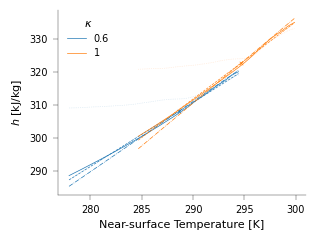

In [599]:
save_h_fig = True
linestyle_fit = ['--', '-.']
labels_fit = ['empirical', '$h$ theory']
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), 
             np.average(mse_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], 
               label=f'{tau_lw[i]}')
    ax.plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), 
             np.average(mse_quant3[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], 
               linestyle=':', alpha=0.2)
    ax.scatter(np.average(temp_mean[i, ind_surf], axis=0, weights=lat_weights), 
               np.average(mse_mean[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], marker='x')
    for j, var in enumerate([mse_empirical_quant3, mse_theory_quant3]):
        ax.plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), 
                np.average(var[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle=linestyle_fit[j])
ax.legend(title='$\kappa$')
ax.set_ylabel('$h$ [kJ/kg]')
ax.set_xlabel('Near-surface Temperature [K]')
if save_h_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/h_{region}_{season}.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

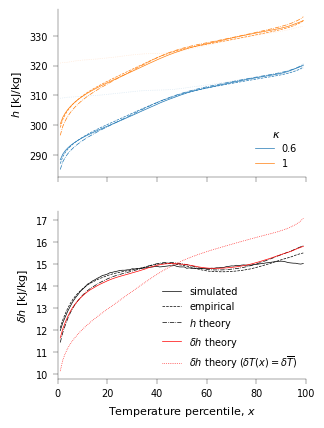

In [600]:
save_h_change_fig = True
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
             np.average(mse_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], 
               label=f'{tau_lw[i]}')
    ax[0].plot(quantiles_all, 
             np.average(mse_quant3[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], 
               linestyle=':', alpha=0.2)
    for j, var in enumerate([mse_empirical_quant3, mse_theory_quant3]):
        ax[0].plot(quantiles_all, np.average(var[i], axis=0, weights=lat_weights), linestyle=linestyle_fit[j], color=default_colors[i])
ax[1].plot(quantiles_all,np.average(mse_quant3[1, ind_surf] - mse_quant3[0, ind_surf], axis=0, weights=lat_weights), 
           color='k', label='simulated')
for j, var in enumerate([mse_empirical_quant3, mse_theory_quant3]):
    ax[1].plot(quantiles_all,np.average(var[1] - var[0], axis=0, weights=lat_weights),
               color='k', linestyle=linestyle_fit[j], label=labels_fit[j])
ax[1].plot(quantiles_all, np.average(delta_mse_theory_quant3, axis=0, weights=lat_weights), color='r', label='$\delta h$ theory')
ax[1].plot(quantiles_all, np.average(delta_mse_theory_const_std_quant3, axis=0, weights=lat_weights), color='r', 
           label='$\delta h$ theory ($\delta T(x) = \delta \overline{T}$)', linestyle=':')
ax[0].set_ylabel('$h$ [kJ/kg]')
ax[1].set_ylabel('$\delta h$ [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].legend(title='$\kappa$')
ax[1].legend()
if save_h_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/h_change_{region}_{season}.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Single Latitude
Below I repeat the above plots for a single latitude.

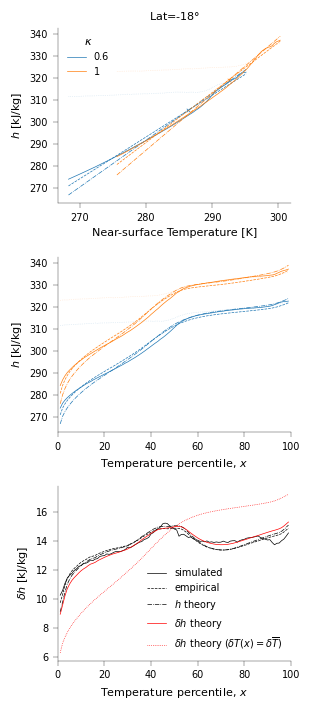

In [726]:
single_lat_ind_use = 0
save_h_single_lat_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar))
ax[1].sharex(ax[2])
for i in range(n_exp):
    for j, x_var in enumerate([temp_quant3[i, ind_surf, single_lat_ind_use], quantiles_all]):
        ax[j].plot(x_var, mse_quant3[i, ind_surf, single_lat_ind_use], color=default_colors[i], 
                   label=f'{tau_lw[i]}')
        ax[j].plot(x_var, mse_quant3[i, ind_ft, single_lat_ind_use], color=default_colors[i], 
                   linestyle=':', alpha=0.2)
        ax[j].plot(x_var, mse_empirical_quant3[i, single_lat_ind_use], linestyle=linestyle_fit[0], color=default_colors[i])
        ax[j].plot(x_var, mse_theory_quant3[i, single_lat_ind_use], linestyle=linestyle_fit[1], color=default_colors[i])
    ax[0].scatter(temp_mean[i, ind_surf, single_lat_ind_use], 
               mse_mean[i, ind_surf, single_lat_ind_use], color=default_colors[i], marker='x')
ax[2].plot(quantiles_all, mse_quant3[1, ind_surf, single_lat_ind_use] - mse_quant3[0, ind_surf, single_lat_ind_use], 
           color='k', label='simulated')
for j, var in enumerate([mse_empirical_quant3, mse_theory_quant3]):
    ax[2].plot(quantiles_all, var[1, single_lat_ind_use] - var[0, single_lat_ind_use],
               color='k', linestyle=linestyle_fit[j], label=labels_fit[j])
ax[2].plot(quantiles_all, delta_mse_theory_quant3[single_lat_ind_use], color='r', label='$\delta h$ theory')
ax[2].plot(quantiles_all, delta_mse_theory_const_std_quant3[single_lat_ind_use], color='r', 
           label='$\delta h$ theory ($\delta T(x) = \delta \overline{T}$)', linestyle=':')
ax[0].legend(title='$\kappa$')
ax[2].legend()
ax[0].set_ylabel('$h$ [kJ/kg]')
ax[1].set_ylabel('$h$ [kJ/kg]')
ax[2].set_ylabel('$\delta h$ [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[2].set_xlabel(percentile_label)
ax[2].set_xlim(0, 100)
ax[0].set_xlabel('Near-surface Temperature [K]')
ax[0].set_title(f'Lat={round(float(ds_all[0].lat[single_lat_ind_use]))}$\degree$')
plt.tight_layout()
if save_h_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/h_single_lat_{region}_{season}.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [602]:
def get_temp_quant_theory_non_conv(temp_mean: np.ndarray, sphum_mean: np.ndarray, temp_quant: np.ndarray, 
                                   sphum_quant: np.ndarray, pressure_surface: float, const_rh: bool = False, 
                                   const_alpha_factor: bool = False, const_sphum_sat: bool = False):
    n_exp, n_quant = temp_quant.shape
    alpha_quant = clausius_clapeyron_factor(temp_quant, pressure_surface)
    alpha_mean = clausius_clapeyron_factor(temp_mean, pressure_surface)
    sphum_quant_sat = sphum_sat(temp_quant, pressure_surface)
    sphum_mean_sat = sphum_sat(temp_mean, pressure_surface)
    r_quant = sphum_quant / sphum_quant_sat
    r_mean = sphum_mean / sphum_mean_sat
    delta_temp_mean = np.diff(temp_mean)
    
    delta_r_mean = np.diff(r_mean)
    delta_r_quant = np.diff(r_quant, axis=0)
    
    if const_rh:
        # get rid of relative humidity contribution if constant rh
        delta_r_mean = 0 * delta_r_mean
        delta_r_quant = 0 * delta_r_quant
    if const_alpha_factor:
        # Assume clausius clapeyron parameter is always equal to the mean value
        for i in range(n_exp):
            alpha_quant[i] = alpha_mean[i]
    if const_sphum_sat:
        # Assumes wherever sphum_sat appears, it can be set to mean value.
        # This only happens as prefactor to delta_r_quant term in numerator
        for i in range(n_exp):
            sphum_quant_sat[i] = sphum_mean_sat[i]
            
    # Pad all delta variables so same size as temp_quant - will not use this in calculation but just makes it easier
    pad_array = ((0, 1), (0, 0))
    delta_temp_mean = np.pad(delta_temp_mean, pad_width=pad_array[0])
    delta_r_mean = np.pad(delta_r_mean, pad_width=pad_array[0])
    delta_r_quant = np.pad(delta_r_quant, pad_width=pad_array)
    
    # Give extra axis to mean terms so can combine with quant terms i.e. change from [n_exp] to [n_exp, 1]
    alpha_mean = alpha_mean[:, np.newaxis]
    sphum_mean = sphum_mean[:, np.newaxis]
    sphum_mean_sat = sphum_mean_sat[:, np.newaxis]
    delta_r_mean = delta_r_mean[:, np.newaxis]
    temp_mean = temp_mean[:, np.newaxis]
    delta_temp_mean = delta_temp_mean[:, np.newaxis]
    
    denominator = alpha_mean * sphum_mean - alpha_quant * sphum_quant
    numerator_r =  (sphum_quant_sat * delta_r_quant - sphum_mean_sat * delta_r_mean
                    ) + alpha_mean * sphum_mean_sat * (temp_quant - temp_mean) * delta_r_mean
    numerator_t = alpha_mean * sphum_mean * (alpha_mean * temp_mean - 2) * (temp_quant/temp_mean - 1) * delta_temp_mean
    
    # lhs = (c_p + L_v * alpha_quant * sphum_quant) * np.pad(np.diff(temp_quant, axis=0), pad_width=pad_array) + L_v * sphum_quant_sat * delta_r_quant
    # rhs = (c_p + L_v * alpha_mean * sphum_mean) * np.pad(np.diff(temp_quant, axis=0), pad_width=pad_array)
    # return lhs[:-1]
    return (numerator_r + numerator_t)[:-1], denominator[:-1]

# i = 0
# plt.plot(get_temp_quant_theory_non_conv(temp_mean[:, ind_surf, i], sphum_mean[:, i], temp_quant3[:, ind_surf, i], sphum_quant3[:, i], p_surface)[0])
# plt.plot(-(temp_quant3[1, ind_surf, i] - temp_quant3[0, ind_surf, i]))
# plt.ylim(-10, 5)

In [603]:
i = 0
a = get_temp_quant_theory_non_conv(temp_mean[:, ind_surf, i], sphum_mean[:, i], temp_quant3[:, ind_surf, i], sphum_quant3[:, i], p_surface)
a/1000

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

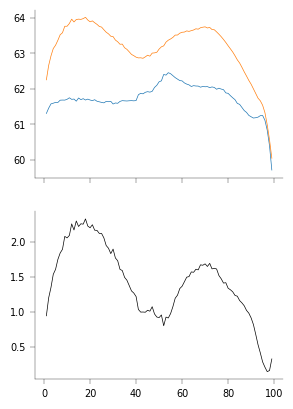

In [604]:
r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface) * 100
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(r_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'{tau_lw[i]}')
ax[1].plot(quantiles_all, 
               np.average(r_quant3[1]-r_quant3[0], axis=0, weights=lat_weights), color='k')

In [605]:
def get_temp_theory1(temp_mean_surf, temp_mean_ft, temp_quant_ft, lapse_mean, lapse_quant):
    """
    Args:
        temp_mean_surf: float
        temp_mean_ft: float
        temp_quant_ft: [n_quant]
        lapse_mean: float
        lapse_quant: [n_quant]

    Returns:
        [n_quant]
    """
    return temp_quant_ft * (1 + lapse_quant * (temp_mean_surf - temp_mean_ft) / (temp_mean_ft * lapse_mean))

def get_temp_theory2(temp_mean_surf, temp_mean_ft, temp_quant_ft, lapse_mean, lapse_quant, lapse_adiabat_mean, lapse_adiabat_quant, z_mean):
    """
    Args:
        temp_mean_surf: float
        temp_mean_ft: float
        temp_quant_ft: [n_quant]
        lapse_mean: float
        lapse_quant: [n_quant]
        lapse_adiabat_mean: float
        lapse_adiabat_quant: [n_quant

    Returns:
        [n_quant]
    """
    temp_ft_diff = (temp_quant_ft - temp_mean_ft) / temp_mean_ft
    lapse_adiabat_fract = lapse_adiabat_quant / lapse_adiabat_mean
    lapse_adiabat_quant_diff = (lapse_quant - lapse_adiabat_quant) / lapse_adiabat_quant
    lapse_adiabat_mean_diff = (lapse_mean - lapse_adiabat_mean) / lapse_adiabat_mean
    # return temp_quant_ft + lapse_adiabat_fract * (temp_mean_surf - temp_mean_ft) * (
    #         1 + temp_ft_diff + lapse_adiabat_quant_diff - lapse_adiabat_mean_diff - lapse_adiabat_quant_diff * lapse_adiabat_mean_diff + lapse_adiabat_mean_diff**2)
    # return temp_quant_ft + lapse_adiabat_fract * (temp_mean_surf - temp_mean_ft) * (
    #         1 + temp_ft_diff) * (1 + lapse_adiabat_quant_diff) / (1 + lapse_adiabat_mean_diff)
    return (1 + temp_ft_diff) * (temp_mean_surf + z_mean * (lapse_quant - lapse_mean))

def get_delta_temp_theory(temp_mean_surf, temp_mean_ft, temp_quant_ft, lapse_mean, lapse_quant, z_mean):
    """
    Assumes n_exp = 2
    Args:
        temp_mean_surf: [n_exp]
        temp_mean_ft: [n_exp]
        temp_quant_ft: [n_exp, n_quant]
        lapse_mean: [n_exp]
        lapse_quant: [n_exp, n_quant]
        z_mean: [n_exp]

    Returns:
        [n_quant]
    """
    temp_ft_diff = (temp_quant_ft - temp_mean_ft[:, np.newaxis]) / temp_mean_ft[:, np.newaxis]
    t500_cont = (temp_ft_diff[1]-temp_ft_diff[0]) * (temp_mean_surf[0] + z_mean[0] * (lapse_quant[0] - lapse_mean[0]))
    tmean_cont = (1+temp_ft_diff[0]) * (temp_mean_surf[1] - temp_mean_surf[0])
    zmean_cont = (1+temp_ft_diff[0]) * (lapse_quant[0] - lapse_mean[0]) * (z_mean[1] - z_mean[0])
    lapse_cont = (1+temp_ft_diff[0]) * z_mean[0] * np.diff((lapse_quant - lapse_mean[:, np.newaxis]), axis=0)
    return t500_cont + tmean_cont + zmean_cont + lapse_cont, tmean_cont, t500_cont, zmean_cont, lapse_cont
    

In [606]:
temp_theory1 = np.zeros((n_exp, n_lat, n_quant_all))
temp_theory2 = np.zeros((n_exp, n_lat, n_quant_all))
delta_temp_theory = np.zeros((n_lat, n_quant_all))
delta_temp_theory_cont = {key: np.zeros((n_lat, n_quant_all)) for key in ['t_surf', 't_ft', 'z_ft', 'lapse']}
for j in range(n_lat):
    delta_temp_theory[j], delta_temp_theory_cont['t_surf'][j], delta_temp_theory_cont['t_ft'][j], \
        delta_temp_theory_cont['z_ft'][j], delta_temp_theory_cont['lapse'][j] = \
        get_delta_temp_theory(temp_mean[:, ind_surf, j], temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], 
                              lapse_mean[:, j], lapse_quant3[:, j], z_mean[:, ind_ft, j])
    for i in range(n_exp):
        temp_theory1[i, j] = get_temp_theory1(temp_mean[i, ind_surf, j], temp_mean[i, ind_ft, j], temp_quant3[i, ind_ft, j], 
                                              lapse_mean[i, j], lapse_quant3[i, j])
        temp_theory2[i, j] = get_temp_theory2(temp_mean[i, ind_surf, j], temp_mean[i, ind_ft, j], temp_quant3[i, ind_ft, j], 
                                              lapse_mean[i, j], lapse_quant3[i, j], lapse_adiabat_mean[i, j], lapse_adiabat_quant3[i, j], 
                                              z_mean[i, ind_ft, j])

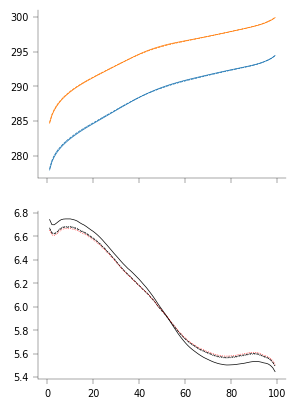

In [607]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], label=f'{tau_lw[i]}')
    ax[0].plot(quantiles_all, np.average(temp_theory1[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle='--')
    ax[0].plot(quantiles_all, np.average(temp_theory2[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
ax[1].plot(quantiles_all, np.average(temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf], axis=0, weights=lat_weights), color='k')
ax[1].plot(quantiles_all, np.average(temp_theory1[1] - temp_theory1[0], axis=0, weights=lat_weights), color='k', linestyle='--')
ax[1].plot(quantiles_all, np.average(temp_theory2[1] - temp_theory2[0], axis=0, weights=lat_weights), color='k', linestyle=':')
ax[1].plot(quantiles_all, np.average(delta_temp_theory, axis=0, weights=lat_weights), color='r', linestyle=':')

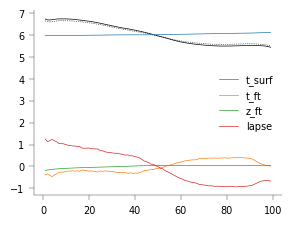

In [608]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quantiles_all, np.average(temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf], axis=0, weights=lat_weights), color='k')
ax.plot(quantiles_all, np.average(delta_temp_theory, axis=0, weights=lat_weights), color='k', linestyle=':')
for i, key in enumerate(delta_temp_theory_cont):
    ax.plot(quantiles_all, np.average(delta_temp_theory_cont[key], axis=0, weights=lat_weights), color=default_colors[i], label=key)
ax.legend()
# ax.axhline(0, color='k', lw=ax_linewidth)



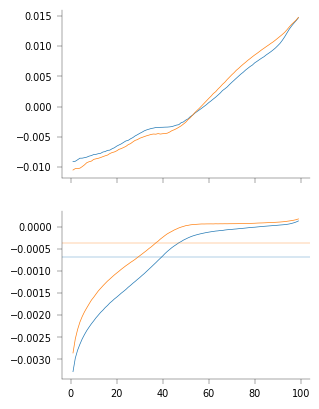

In [609]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average((temp_quant3[i, ind_ft] - temp_mean[i, ind_ft][:, np.newaxis])/temp_mean[i, ind_ft][:, np.newaxis], axis=0, weights=lat_weights), color=default_colors[i], label=f'{tau_lw[i]}')
    ax[1].plot(quantiles_all, np.average((lapse_quant3[i] - lapse_adiabat_quant3[i]), 
                                         axis=0, weights=lat_weights))
    ax[1].axhline(np.average((lapse_mean[i] - lapse_adiabat_mean[i]), 
                                         axis=0, weights=lat_weights), color=default_colors[i], lw=ax_linewidth)

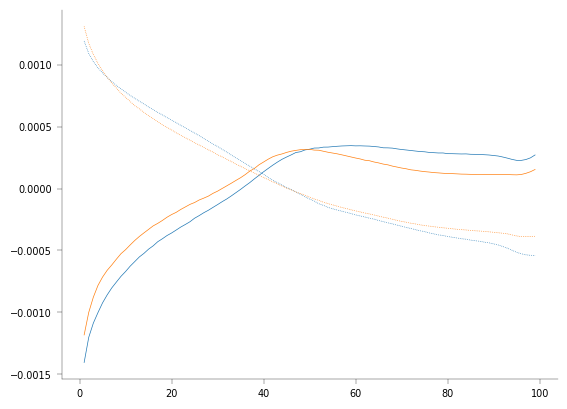

In [610]:
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
ax = [ax]
for i in range(n_exp):
    ax[0].plot(quantiles_all, np.average(lapse_quant3[i] - lapse_mean[i][:, np.newaxis], 
                                         axis=0, weights=lat_weights), color=default_colors[i])
    ax[0].plot(quantiles_all, np.average(lapse_adiabat_quant3[i] - lapse_adiabat_mean[i][:, np.newaxis], 
                                         axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
    # a = (lapse_quant3[i] - lapse_adiabat_quant3[i]) /lapse_adiabat_quant3[i]
    # b = ((lapse_mean[i] - lapse_adiabat_mean[i]) /lapse_adiabat_mean[i])[:, np.newaxis]
    # ax[0].plot(quantiles_all, np.average(lapse_adiabat_quant3[i] / lapse_adiabat_mean[i][:, np.newaxis] * (
    #         1 + a - b - a*b), 
    #                                      axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
    # ax[0].plot(quantiles_all, np.average(lapse_adiabat_quant3[i] / lapse_adiabat_mean[i][:, np.newaxis] * (
    #         1 + a)*(1-b+0.5*b**2), 
    #                                      axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.3)

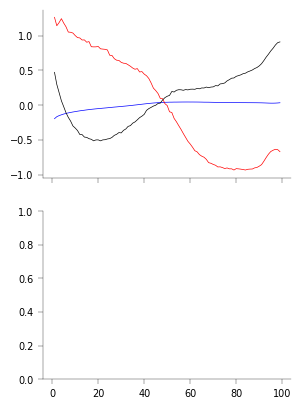

In [611]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quantiles_all, np.average((lapse_quant3[0] - lapse_mean[0][:, np.newaxis]) * (z_mean[1, ind_ft] - z_mean[0, ind_ft])[:, np.newaxis], 
                                     axis=0, weights=lat_weights), color='b')
ax[0].plot(quantiles_all, np.average(z_mean[0, ind_ft][:, np.newaxis] * np.diff(lapse_quant3 - lapse_mean[:, :, np.newaxis], axis=0)[0], axis=0, weights=lat_weights), color='r')
ax[0].plot(quantiles_all, np.average(z_mean[0, ind_ft][:, np.newaxis] * np.diff(lapse_adiabat_quant3 - lapse_adiabat_mean[:, :, np.newaxis], axis=0)[0] + (lapse_quant3[0] - lapse_mean[0][:, np.newaxis]) * (z_mean[1, ind_ft] - z_mean[0, ind_ft])[:, np.newaxis], axis=0, weights=lat_weights), color='k')

## MSE Perspective

In [634]:
def get_mse_ft_sat(temp_ft, kappa, pressure=pressure_ft_actual):
    """
    Function for computing saturated MSE from just free troposphere temperature.
    Args:
        temp_ft: [n_quant]
        kappa: [n_quant] or float
            Can either provide kappa (z/T ratio) for each quantile or just a single kappa value.
        pressure: float
            Free troposphere pressure in Pa.

    Returns:
        [n_quant]
            MSE in kJ/kg
    """
    return (c_p * temp_ft + L_v * sphum_sat(temp_ft, pressure) + g * kappa * temp_ft)/1000

def lambda_adiabat_fit_func_with_kappa(temp_ft, mse_surf, kappa):
    # Adiabatic FT temperature is such that surf MSE equals free trop MSE
    return get_mse_ft_sat(temp_ft, kappa) - mse_surf

In [643]:
# Repeat calculation of adiabatic free troposphere temperature, but this time let height vary with temperature
temp_adiabat_mean_with_kappa = np.zeros((n_exp, n_lat))
temp_adiabat_quant3_with_kappa = np.zeros((n_exp, n_lat, n_quant_all))
for i in range(n_exp):
    for j in range(n_lat):
        temp_adiabat_mean_with_kappa[i, j] = scipy.optimize.fsolve(lambda_adiabat_fit_func_with_kappa, 273, 
                                                                            args=(mse_mean[i, ind_surf, j], kappa_mean[i, j]))
        for k in range(n_quant_all):
            # MAYBE SHOULD COMPUTE THIS WITH kappa_quant. CHECK IF MAKES A DIFFERENCE!!
            temp_adiabat_quant3_with_kappa[i, j, k] = scipy.optimize.fsolve(lambda_adiabat_fit_func_with_kappa, 273, 
                                                                            args=(mse_quant3[i, ind_surf, j, k], kappa_mean[i, j]))

Text(0, 0.5, '$\\delta \\kappa$ [m/K]')

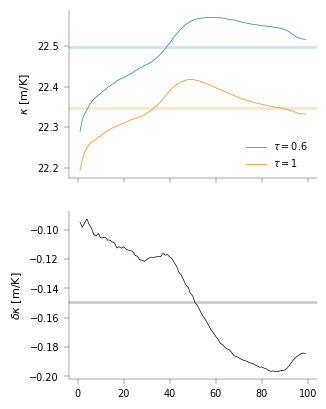

In [613]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(kappa_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].axhline(np.average(kappa_mean[i], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
ax[1].plot(quantiles_all, np.average(kappa_quant3[1] - kappa_quant3[0], axis=0, weights=lat_weights), color='k')
ax[1].axhline(np.average(kappa_mean[1] - kappa_mean[0], axis=0, weights=lat_weights), color='k', lw=2, alpha=0.2)
ax[0].legend()
ax[0].set_ylabel('$\kappa$ [m/K]')
ax[1].set_ylabel('$\delta \kappa$ [m/K]')

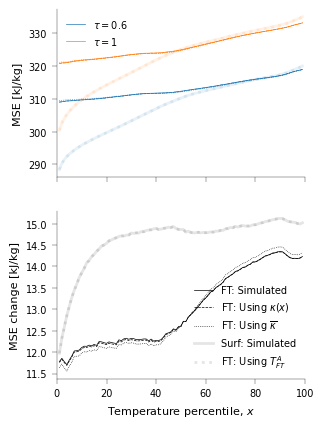

In [650]:
save_mse_ft_fig = False
mse_ft_sat_quant3 = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['kappa_x', 'kappa_mean', 'temp_adiabat']}
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    for j in range(n_lat):
        mse_ft_sat_quant3['kappa_x'][i, j] = get_mse_ft_sat(temp_quant3[i, ind_ft, j], kappa_quant3[i, j])
        mse_ft_sat_quant3['kappa_mean'][i, j] = get_mse_ft_sat(temp_quant3[i, ind_ft, j], kappa_mean[i, j])
        mse_ft_sat_quant3['temp_adiabat'][i, j] = get_mse_ft_sat(temp_adiabat_quant3_with_kappa[i, j], kappa_mean[i, j])
    ax[0].plot(quantiles_all, 
            np.average(mse_quant3[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].plot(quantiles_all, np.average(mse_ft_sat_quant3['kappa_x'][i], axis=0, weights=lat_weights), 
               color=default_colors[i], linestyle='--')
    ax[0].plot(quantiles_all, np.average(mse_ft_sat_quant3['kappa_mean'][i], axis=0, weights=lat_weights), 
               color=default_colors[i], linestyle=':')
    ax[0].plot(quantiles_all, np.average(mse_quant3[i, ind_surf], axis=0, weights=lat_weights), 
               color=default_colors[i], lw=2, alpha=0.1)
    ax[0].plot(quantiles_all, np.average(mse_ft_sat_quant3['temp_adiabat'][i], axis=0, weights=lat_weights), 
               color=default_colors[i], lw=2, alpha=0.1, linestyle=':')
ax[1].plot(quantiles_all, np.average(mse_quant3[1, ind_ft] - mse_quant3[0, ind_ft], axis=0, weights=lat_weights), color='k',
           label='FT: Simulated')
ax[1].plot(quantiles_all, np.average(mse_ft_sat_quant3['kappa_x'][1] - mse_ft_sat_quant3['kappa_x'][0], axis=0, weights=lat_weights),
           color='k', linestyle='--', label='FT: Using $\kappa(x)$')
ax[1].plot(quantiles_all, np.average(mse_ft_sat_quant3['kappa_mean'][1] - mse_ft_sat_quant3['kappa_mean'][0], axis=0, weights=lat_weights),
           color='k', linestyle=':', label='FT: Using $\overline{\kappa}$')
ax[1].plot(quantiles_all, np.average(mse_quant3[1, ind_surf] - mse_quant3[0, ind_surf], axis=0, weights=lat_weights), color='k', 
           lw=2, alpha=0.1, label='Surf: Simulated')
ax[1].plot(quantiles_all, np.average(mse_ft_sat_quant3['temp_adiabat'][1] - mse_ft_sat_quant3['temp_adiabat'][0], axis=0,
                                     weights=lat_weights), color='k', lw=2, alpha=0.1, linestyle=':', label='FT: Using $T^A_{FT}$')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('MSE [kJ/kg]')
ax[1].set_ylabel('MSE change [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
if save_fig or save_mse_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_ft_sat_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [790]:
def get_h_anom_theory(temp_adiabat_mean, temp_adiabat_quant, kappa_mean, kappa_quant = None, p_ft = pressure_ft_actual,
                      include_squared_term=False):
    """
        Get h - h_mean theory using taylor expansion and free troposphere adiabatic temperatures.
    Args:
        temp_adiabat_mean: float
        temp_adiabat_quant: [n_quant]
        kappa_mean: float
        kappa_quant: [n_quant]
            If not given, assumes kappa_quant = kappa_mean i.e. no anomaly
        p_ft: float
        include_squared_term: bool

    Returns:
        [n_quant]
            MSE anomaly in kJ/kg
    """
    temp_adiabat_anom = temp_adiabat_quant - temp_adiabat_mean
    if kappa_quant is None:
        kappa_anom = 0
    else:
        kappa_anom = kappa_quant - kappa_mean
    alpha_mean = clausius_clapeyron_factor(temp_adiabat_mean, p_ft)
    q_sat_mean = sphum_sat(temp_adiabat_mean, p_ft)
    if include_squared_term:
        squared_term = 0.5 * L_v * alpha_mean * q_sat_mean / temp_adiabat_mean * (alpha_mean * temp_adiabat_mean - 2) * temp_adiabat_anom**2
    else:
        squared_term = 0
    return (c_p * temp_adiabat_anom + 
            L_v * q_sat_mean * alpha_mean * temp_adiabat_anom + 
            g * kappa_mean * temp_adiabat_anom + g * temp_adiabat_mean * kappa_anom + squared_term)/1000

def get_delta_temp_adiabat_mean_theory(temp_adiabat_mean, kappa_mean, mse_surf_mean, 
                                       temp_surf_mean = None, sphum_surf_mean = None, p_ft=pressure_ft_actual, p_surface=p_surface):
    """
    Assumes n_exp=2
    Args:
        temp_adiabat_mean: [n_exp]
        kappa_mean: [n_exp]
        mse_surf_mean: [n_exp]
            In units of kJ/kg
            If given, computes the exact difference in MSE surface. Otherwise, does linear expansion with temp_surf and sphum_surf.
        temp_surf_mean: [n_exp]
        sphum_surf_mean: [n_exp]
        p_ft: float (Pa)
        p_surface: float (Pa)

    Returns:
        float
    """
    if mse_surf_mean is not None:
        delta_mse = (mse_surf_mean[1] - mse_surf_mean[0]) * 1000        # convert into units of J/kg
    else:
        # Do linear taylor expansion to compute delta_mse if actual value not given
        delta_rh = float(np.diff(sphum_surf_mean / sphum_sat(temp_surf_mean, p_surface)))
        delta_temp_surf = temp_surf_mean[1] - temp_surf_mean[0]
        alpha_surf = clausius_clapeyron_factor(temp_surf_mean[0], p_surface)
        q_sat_surf = sphum_sat(temp_surf_mean[0], p_surface)
        delta_mse = (c_p + L_v * sphum_surf_mean[0] * alpha_surf) * delta_temp_surf + L_v * q_sat_surf * delta_rh
    delta_kappa = kappa_mean[1] - kappa_mean[0]
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    return (delta_mse - g * temp_adiabat_mean[0] * delta_kappa) / (c_p + L_v * alpha * q_sat + g * kappa_mean[0])

def get_delta_h_anom_theory(temp_adiabat_mean, temp_adiabat_quant, delta_temp_adiabat_mean, kappa_mean, kappa_quant = None,
                            include_squared_term=False, p_ft=pressure_ft_actual):
    """
    
    Args:
        temp_adiabat_mean: [n_exp]
        temp_adiabat_quant: [n_exp, n_quant]
        delta_temp_adiabat_mean: float
        kappa_mean: [n_exp]
        kappa_quant: [n_exp, n_quant]
        include_squared_term: bool
        p_ft: float

    Returns:
        [n_quant]
    """
    temp_anom = temp_adiabat_quant - temp_adiabat_mean[:, np.newaxis]
    delta_temp_anom = temp_anom[1] - temp_anom[0]
    if kappa_quant is None:
        kappa_anom = np.zeros_like(temp_anom)
    else:
        kappa_anom = kappa_quant - kappa_mean[:, np.newaxis]
    delta_kappa_mean = kappa_mean[1] - kappa_mean[0]
    delta_kappa_anom = kappa_anom[1] - kappa_anom[0]
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    
    temp_anom_prefactor = c_p + g * kappa_mean[0] + L_v * q_sat * alpha
    temp_mean_prefactor = g * kappa_anom[0] + L_v * q_sat * alpha / temp_adiabat_mean[0] * (temp_adiabat_mean[0] * alpha - 2) * temp_anom[0]
    kappa_anom_prefactor = g * temp_adiabat_mean[0]
    kappa_mean_prefactor = g * temp_anom[0]
    if include_squared_term:
        temp_anom_squared_prefactor = 0.5 * L_v * q_sat * alpha / temp_adiabat_mean[0] * (temp_adiabat_mean[0] * alpha - 2)
        temp_anom_prefactor = temp_anom_prefactor + 2 * temp_anom_squared_prefactor * temp_anom[0]
        temp_mean_squared_prefactor = 0.5 * L_v * q_sat * alpha / temp_adiabat_mean[0]**2 * (
                alpha**2 * temp_adiabat_mean[0]**2 - 6 * alpha * temp_adiabat_mean[0] + 6) * temp_anom[0]  # only include one term
        temp_mean_prefactor = temp_mean_prefactor + temp_mean_squared_prefactor * temp_anom[0]
    else:
        temp_anom_squared_prefactor = 0
        temp_mean_squared_prefactor = 0
        
    # Convert into units of kJ/kg
    temp_anom_prefactor = temp_anom_prefactor/1000
    temp_anom_squared_prefactor = temp_anom_squared_prefactor/1000
    kappa_anom_prefactor = kappa_anom_prefactor/1000
    kappa_mean_prefactor = kappa_mean_prefactor/1000
    temp_mean_prefactor = temp_mean_prefactor/1000
    temp_mean_squared_prefactor = temp_mean_squared_prefactor/1000
    full_answer = temp_anom_prefactor * delta_temp_anom + temp_anom_squared_prefactor * delta_temp_anom**2 + \
                  kappa_anom_prefactor * delta_kappa_anom + kappa_mean_prefactor * delta_kappa_mean + \
                  temp_mean_prefactor * delta_temp_adiabat_mean + temp_mean_squared_prefactor * delta_temp_adiabat_mean**2
    info_dict = {'temp_anom': [temp_anom_prefactor, delta_temp_anom], 
                 'temp_anom_squared': [temp_anom_squared_prefactor, delta_temp_anom**2],
                 'temp_mean': [temp_mean_prefactor, delta_temp_adiabat_mean],
                 'temp_mean_squared': [temp_mean_squared_prefactor, delta_temp_adiabat_mean**2],
                 'kappa_anom': [kappa_anom_prefactor, delta_kappa_anom], 
                 'kappa_mean': [kappa_mean_prefactor, delta_kappa_mean]}
    return full_answer, info_dict

In [805]:
delta_temp_adiabat_mean = {'simulated': temp_adiabat_mean_with_kappa[1]-temp_adiabat_mean_with_kappa[0], 
                           'full_delta_mse': np.zeros(n_lat), 'linear_delta_mse': np.zeros(n_lat)}
h_anom_theory = {'linear': np.zeros((n_exp, n_lat, n_quant_all)), 'squared': np.zeros((n_exp, n_lat, n_quant_all))}
delta_h_anom = {'simulated': np.diff(mse_quant3[:, ind_surf] - mse_mean[:, ind_surf][:, :, np.newaxis], axis=0)[0], 
                'linear': np.zeros((n_lat, n_quant_all)), 'squared': np.zeros((n_lat, n_quant_all))}
delta_h_anom_theory_prefactors = {key: np.zeros((n_lat, n_quant_all)) for key in 
                           ['temp_anom', 'temp_anom_squared', 'temp_mean', 'temp_mean_squared', 'kappa_anom', 'kappa_mean']}
delta_h_anom_theory_diff = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_prefactors}
delta_h_anom_theory_cont = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_prefactors}
for j in range(n_lat):
    for key in ['full_delta_mse', 'linear_delta_mse']:
        delta_temp_adiabat_mean[key][j] = \
            get_delta_temp_adiabat_mean_theory(temp_adiabat_mean_with_kappa[:, j], 
                                               kappa_mean[:, j], None if 'linear' in key else mse_mean[:, ind_surf, j], 
                                               temp_mean[:, ind_surf, j], sphum_mean[:, j])[0]
    for key in ['linear', 'squared']:
        # I use full_delta_mse here for delta_temp_adiabat_mean term, but doesn't make too much difference.
        delta_h_anom[key][j], info = get_delta_h_anom_theory(temp_adiabat_mean_with_kappa[:, j], temp_adiabat_quant3_with_kappa[:, j],
                                                          delta_temp_adiabat_mean['full_delta_mse'][j], kappa_mean[:, j],
                                                          include_squared_term=True if key=='squared' else False)
        if key == 'linear':
            # Only get individual contributions from linear theory
            for key in info:
                delta_h_anom_theory_prefactors[key][j] = info[key][0]
                delta_h_anom_theory_diff[key][j] = info[key][1]
                delta_h_anom_theory_cont[key][j] = delta_h_anom_theory_prefactors[key][j] * delta_h_anom_theory_diff[key][j]
    for i in range(n_exp):
        for key in h_anom_theory:
            h_anom_theory[key][i, j] = get_h_anom_theory(temp_adiabat_mean_with_kappa[i, j], temp_adiabat_quant3_with_kappa[i, j],
                                                         kappa_mean[i, j], include_squared_term=True if key=='squared' else False)

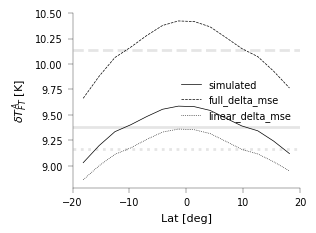

In [793]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
linestyles_use = ['-', '--', ':']
for i, key in enumerate(delta_temp_adiabat_mean):
    ax.plot(ds_all[0].lat, delta_temp_adiabat_mean[key], color='k', label=key, linestyle=linestyles_use[i])
    ax.axhline(np.average(delta_temp_adiabat_mean[key], weights=lat_weights, axis=0), color='k', 
               linestyle=linestyles_use[i], lw=2, alpha=0.1)
ax.set_xlim(-lat_max, lat_max)
ax.set_ylabel('$\delta T_{FT}^A$ [K]')
ax.set_xlabel('Lat [deg]')
ax.legend()
plt.tight_layout()

Below, the linear red line captures the broad trend we are after.

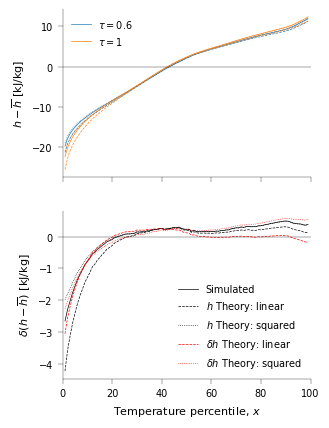

In [796]:
save_mse_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(mse_quant3[i, ind_surf] - mse_mean[i, ind_surf][:, np.newaxis], axis=0, weights=lat_weights),
               color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].plot(quantiles_all, 
               np.average(h_anom_theory['linear'][i], axis=0, weights=lat_weights),
               color=default_colors[i], linestyle='--')
    ax[0].plot(quantiles_all, 
               np.average(h_anom_theory['squared'][i], axis=0, weights=lat_weights),
               color=default_colors[i], linestyle=':')
ax[1].plot(quantiles_all, np.average(delta_h_anom['simulated'], 
                                     axis=0, weights=lat_weights), color='k', label='Simulated')
ax[1].plot(quantiles_all, np.average(np.diff(h_anom_theory['linear'], axis=0)[0], axis=0, weights=lat_weights), 
           color='k', linestyle='--', label='$h$ Theory: linear')
ax[1].plot(quantiles_all, np.average(np.diff(h_anom_theory['squared'], axis=0)[0], axis=0, weights=lat_weights), 
           color='k', linestyle=':', label='$h$ Theory: squared')
ax[1].plot(quantiles_all, np.average(delta_h_anom['linear'], axis=0, weights=lat_weights), 
           color='r', linestyle='--', label='$\delta h$ Theory: linear')
ax[1].plot(quantiles_all, np.average(delta_h_anom['squared'], axis=0, weights=lat_weights), 
           color='r', linestyle=':', label='$\delta h$ Theory: squared')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$h-\overline{h}$ [kJ/kg]')
ax[1].set_ylabel('$\delta (h-\overline{h})$ [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_mse_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

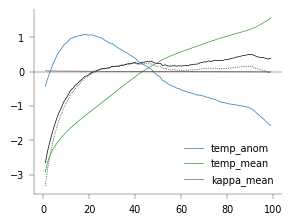

In [814]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quantiles_all, np.average(delta_h_anom['simulated'], 
                                     axis=0, weights=lat_weights), color='k')
ax.plot(quantiles_all, np.average(delta_h_anom['linear'], axis=0, weights=lat_weights), 
           color='k', linestyle=':')
for i, key in enumerate(delta_h_anom_theory_cont):
    if ('squared' in key) or (key == 'kappa_anom'):
        continue
    ax.plot(quantiles_all, np.average(delta_h_anom_theory_cont[key], axis=0, weights=lat_weights), 
           color=default_colors[i], label=key)
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)